In [1]:
%pylab inline
import pywt
import numpy as np
import seaborn
from statsmodels.robust import mad
import mysql.connector

Populating the interactive namespace from numpy and matplotlib


5.901757598160639
8.387146624871479
['19' '5.901757598160639' '8.387146624871479']
INSERT INTO test0.new_table(c1,c2,c3) VALUES(19,5.901757598160639,8.387146624871479)


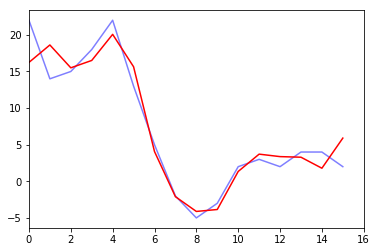

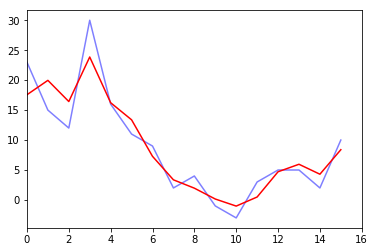

In [2]:
# define denoise function
# site from Connor Johnson's blog
def waveletSmooth( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    f, ax = plt.subplots()
    plot( x, color="b", alpha=0.5 )
    plot( y, color="r" )
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(y)))
    return y
    
id_max_num_pre = 1
    
# set link to mysql    
cnx = mysql.connector.connect(user='root', password='941012',
                              host='127.0.0.1',
                              database='test0')
cursor = cnx.cursor()
# Find the max id and select the mewest 15 lines
query = ("SELECT max(id) FROM test0.test")
cursor.execute(query)
result2=cursor.fetchall()
id_list = list(result2)
id_max = np.array(id_list)
id_max_num = str(id_max[0][0])
id_min_num = str(id_max[0][0] - 15)
y_out = id_max_num

if id_max_num > id_max_num_pre:
    query = ("SELECT * FROM test0.test WHERE id <= " + id_max_num + " and id >= " + id_min_num)
    cursor.execute(query)
    columns=cursor.column_names
    result=cursor.fetchall()

    #get list
    x_list = list(result)
    c = np.array(x_list)
    a = c.shape[0]
    b = c.shape[1]
    
    #denoise for each column
    for i in range(2,b+1):
        x = c[:,i-1]

        #denoise
        y = waveletSmooth( x, "db4", 1, None)
        print y[a-1]
        y_out = np.append(y_out, y[a-1])
        
    print y_out
    
    #compile the insert instruct
    ins = ("INSERT INTO test0.new_table(c1,c2,c3) VALUES(")
    for j in range(1,b+1):
        ins = (ins + y_out[j-1])
        if j != b:
            ins = (ins + ",")
    ins = (ins + ")")    
    print ins
    # insert the smooth data to a new table
    cursor.execute(ins)
    cnx.commit()
    #refresh id_max_num_pre
    id_max_num_pre = id_max_num
    #print id_max_num_pre

In [3]:
# close the link
cursor.close()
cnx.close()